In [314]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from numpy import mean
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, confusion_matrix, roc_auc_score, f1_score, log_loss, precision_score, recall_score, silhouette_score
from xgboost import XGBClassifier, DMatrix, train, cv
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# **Overview Base**

### Carrega base

In [2]:
dados = pd.read_csv("train.csv", delimiter=',')

In [3]:
dados

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,151829,2,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,60926.490000,0
76016,151830,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118634.520000,0
76017,151835,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74028.150000,0
76018,151836,2,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84278.160000,0


### Verifica tamanho da base e resumo da distribuição das variáveis

In [4]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


In [ ]:
dados.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76020 entries, 0 to 76019
Columns: 371 entries, ID to TARGET
dtypes: float64(111), int64(260)
memory usage: 215.2 MB


### Verificar se há valores missing padroes

In [5]:
#Verificando se ha valores missing padrao (None, NaN) na base como um todo 
dados.isnull().sum().sum()

0

### Verificar se há duplicação na base

In [6]:
dados_nodup = dados.drop_duplicates()
dados_nodup.shape

(76020, 371)

### Separa base de Treino e Teste e verificar proporção da Target

In [7]:
#Separa a base em 70% treino e 30% teste, estratificada pela TARGET, uma vez que ela nao tem uma proporcao equilibrada na base
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(dados_nodup, test_size=0.3,stratify=dados_nodup['TARGET'],random_state=42)
train_set.shape, test_set.shape

((53214, 371), (22806, 371))

In [8]:
df = pd.DataFrame(train_set.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/train_set.shape[0]
df

,TARGET,Percentage
0,51108,96.042395
1,2106,3.957605


In [9]:
df = pd.DataFrame(test_set.TARGET.value_counts())
df['Percentage'] = 100*df['TARGET']/test_set.shape[0]
df

,TARGET,Percentage
0,21904,96.0449
1,902,3.9551


# **Tratamento da Base**

### Remove variáveis duplicadas

In [10]:
features = train_set.drop(['TARGET','ID'],axis=1)
corr_matrix = features.corr()
corr_matrix.shape

(369, 369)

In [11]:
#como a matriz de correlacao se repete na diagonal superior e inferior, escolhi uma delas 
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(np.bool)) 

In [12]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] == 1)] 
print(to_drop)

['ind_var18', 'ind_var26', 'ind_var25', 'ind_var29_0', 'ind_var29', 'ind_var32', 'ind_var37', 'ind_var39', 'num_var18', 'num_var26', 'num_var25', 'num_var29_0', 'num_var29', 'num_var32', 'num_var37', 'num_var39', 'saldo_var29', 'delta_num_aport_var33_1y3', 'delta_num_reemb_var13_1y3', 'delta_num_reemb_var17_1y3', 'delta_num_trasp_var17_in_1y3', 'delta_num_trasp_var17_out_1y3', 'delta_num_trasp_var33_in_1y3', 'delta_num_trasp_var33_out_1y3', 'delta_num_venta_var44_1y3']


In [13]:
print(len(to_drop))

25


In [14]:
features_1 = features.drop(to_drop, axis=1)
features_1.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


In [ ]:
features_1.shape

(53214, 287)

### Remove variáveis constantes

In [15]:
#REMOVER VARIAVEIS CONSTANTES, OU SEJA, COM VARIANCIA ZERO

from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=0)
sel.fit(features_1)  # fit encontra variaveis com variancia zero
#get_support() eh um vetor que indica quais variaveis NAO tem variancia zero
to_drop_2 = [column for column in features_1.columns if column not in features_1.columns[sel.get_support()]] 
print(to_drop_2)

['ind_var2_0', 'ind_var2', 'ind_var13_medio_0', 'ind_var13_medio', 'ind_var27_0', 'ind_var28_0', 'ind_var28', 'ind_var27', 'ind_var34_0', 'ind_var34', 'ind_var41', 'ind_var46_0', 'ind_var46', 'num_var13_medio_0', 'num_var13_medio', 'num_var27_0', 'num_var28_0', 'num_var28', 'num_var27', 'num_var34_0', 'num_var34', 'num_var41', 'num_var46_0', 'num_var46', 'saldo_var13_medio', 'saldo_var28', 'saldo_var27', 'saldo_var34', 'saldo_var41', 'saldo_var46', 'delta_imp_amort_var34_1y3', 'delta_imp_reemb_var33_1y3', 'delta_num_reemb_var33_1y3', 'imp_amort_var18_hace3', 'imp_amort_var34_hace3', 'imp_amort_var34_ult1', 'imp_reemb_var13_hace3', 'imp_reemb_var17_hace3', 'imp_reemb_var33_hace3', 'imp_reemb_var33_ult1', 'imp_trasp_var17_out_hace3', 'imp_trasp_var33_out_hace3', 'num_var2_0_ult1', 'num_var2_ult1', 'num_meses_var13_medio_ult3', 'num_reemb_var13_hace3', 'num_reemb_var17_hace3', 'num_reemb_var33_hace3', 'num_reemb_var33_ult1', 'num_trasp_var17_out_hace3', 'num_trasp_var33_out_hace3', 'saldo

In [16]:
print(len(to_drop_2))

57


In [17]:
features_2= features_1.drop(to_drop_2, axis=1)
features_2.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


In [18]:
features_2.shape

(53214, 287)

# **Feature Selection**

### Agrupa variáveis por nomes em comum

In [19]:
dict = {'full': features_2.columns}
colunas = pd.DataFrame(dict)

colunas['abv'] = colunas['full'].str.slice(0,3)
colunas

,full,abv
0,var3,var
1,var15,var
2,imp_ent_var16_ult1,imp
3,imp_op_var39_comer_ult1,imp
4,imp_op_var39_comer_ult3,imp
...,...,...
282,saldo_medio_var44_hace2,sal
283,saldo_medio_var44_hace3,sal
284,saldo_medio_var44_ult1,sal
285,saldo_medio_var44_ult3,sal


In [20]:
colunas.groupby('abv').count()

,full
abv,
del,15
imp,40
ind,54
num,115
sal,58
var,5


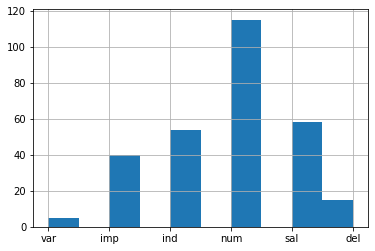

In [21]:
colunas.abv.hist()

### Separa variáveis em Binárias, Categóricas e Contínuas

In [157]:
#TENTAR DETERMINAR SE AS VARIAVEIS SAO BINARIAS, CATEGORICAS OU CONTINUAS

#PRIMEIRO VERIFICOU-SE A QUANTIDADE DE DOMINIOS DE CADA VARIAVEL DA BASE E TENTOU-SE AGRUPAR POR QUANTIDADE DE DOMINIOS
#BINARIAS: 2 DOMINIOS
#CATEGORICAS ATE 10 DOMINIOS: DE 3 A 10 DOMINIOS OU VARS COM INICIO DO NOME DA VARIAVEL NUM (TODAS ELAS PARECEM TER
# APENAS VALORES INTEIROS ATRAVES DO DESCRIBE), REMOVENDO VARIAVEIS COM VALORES NAO INTEIROS (ELAS SE TORNAM CONTINUAS)
#CONTINUAS: FOI FEITO UM TRABALHO DE VERIFICAR QUAL ERA UMA QUANTIDADE MINIMA DE DOMINIOS NECESSARIOS PARA A VARIAVEL
# DEIXAR DE SER CATEGORICA E SE TORNAR CONTINUA, INICIOU-SE O TESTE VERIFICANDO SE A QUANTIDADE DE DOMINIOS ERA MAIOR
# QUE N/2 E FOI-SE DIMINUINDO E VERIFICANDO QUAIS VARIAVEIS ALI TINHAM NOMES PARECIDOS, ALEM DE VERIFICAR SE O DESCRIBE
# MOSTRAVA VALORES QUEBRADOS OU VALORES INTEIROS.
#  VARS COM INICIO DO NOME DA VARIAVEL SALDO, IMP OU DELTA (-1 A 1)


#VETORES DE TESTE
vars_bin = []
vars_cat10 = []
vars_cont = []

vars_bin = [columns for columns in features_2.columns if len(features_2[columns].value_counts()) == 2]

vars_cat10 = [columns for columns in features_2.columns 
              if columns not in vars_bin
              and len(features_2[columns].value_counts()) <= 10]
#vars_cont = [columns for columns in features_2.columns if len(features_2[columns].value_counts()) > 10 and len(features_2[columns].value_counts()) > int((features_2.shape[0])/500)]
vars_cont = [columns for columns in features_2.columns 
             if columns not in vars_bin 
             and columns not in vars_cat10]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10))
print('#Continuas',len(vars_cont))
#APARENTEMENTE:
#BINARIAS: com 2 categorias
#CATEGORICAS: com 3 categorias
#CONTINUAS: SALDO ou IMP ou DELTA (-1 A 1)
#CATEGORICAS: NUM ou ate 10 categorias


#Binarias 80
#Ate 10 categorias 78
#Continuas 129


In [159]:
#VERIFICA SE AS VARIAVEIS CONSIDERADAS CATEGORICAS SAO INTEIROS NAO NEGATIVOS, CASO CONTRARIO, CHAMAR DE CONTINUAS

var_cat_true = []

var_cat_true = [columns for columns in features_2[vars_cat10].columns 
                if np.array_equal(features_2[columns], features_2[columns].astype(int))
                and np.array_equal(features_2[columns], abs(features_2[columns]))]
print(len(var_cat_true))

60


In [160]:
vars_to_cont = []

vars_to_cont = [columns for columns in features_2[vars_cat10].columns if columns not in var_cat_true]
print(len(vars_to_cont))

18


In [26]:
vars_cont_2 = []
vars_cat10_2 = []

vars_cont_2 = [columns for columns in features_2.columns if columns in vars_cont or columns in vars_to_cont]
vars_cat10_2 = [columns for columns in features_2[vars_cat10].columns if columns not in vars_to_cont]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10_2))
print('#Continuas',len(vars_cont_2))

#Binarias 80
#Ate 10 categorias 60
#Continuas 147


### Verifica Associação de Variáveis Categóricas com a TARGET

##### Utiliza teste Chi-Squared para verificar associação entre Variáveis Categóricas e a TARGET

In [28]:
chi_scores = chi2(train_set[vars_cat10_2],train_set['TARGET'])

scores = pd.Series(chi_scores[0], index=vars_cat10_2)
pvalues = pd.Series(chi_scores[1], index=vars_cat10_2)

teste_chi = pd.DataFrame({'Chi2':scores, 'p-Value':pvalues})
teste_chi['associacao'] = teste_chi[teste_chi['p-Value'] <= 0.05]['p-Value']
teste_chi

,Chi2,p-Value,associacao
num_var1_0,2.056941,1.515141e-01,NaN
num_var4,245.491116,2.497193e-55,2.497193e-55
num_var5_0,7.597927,5.843544e-03,5.843544e-03
num_var5,987.652698,8.672433e-217,8.672433e-217
num_var8_0,375.266455,1.335196e-83,1.335196e-83
num_var12_0,85.862875,1.928557e-20,1.928557e-20
num_var12,156.720950,5.890152e-36,5.890152e-36
num_var13_0,240.497758,3.063180e-54,3.063180e-54
num_var13_corto_0,168.619793,1.481237e-38,1.481237e-38
num_var13_corto,171.138710,4.173166e-39,4.173166e-39


##### Remove Variáveis Categóricas sem associação estatisticamente significativa com a TARGET

In [29]:
to_drop_3 = []
to_drop_3 = [columns for columns in teste_chi[teste_chi['p-Value'] > 0.05].index]
print(len(to_drop_3))

20


In [30]:
vars_cat10_3 = []

vars_cat10_3 = [columns for columns in features_2[vars_cat10_2].columns if columns not in to_drop_3]
print('#Binarias',len(vars_bin))
print('#Ate 10 categorias',len(vars_cat10_3))
print('#Continuas',len(vars_cont_2))

#Binarias 80
#Ate 10 categorias 40
#Continuas 147


##### Utiliza teste Chi-Squared para verificar associação entre Variáveis Binárias e a TARGET

In [32]:
chi_scores = chi2(train_set[vars_bin],train_set['TARGET'])

scores = pd.Series(chi_scores[0], index=vars_bin)
pvalues = pd.Series(chi_scores[1], index=vars_bin)

teste_chi_bin = pd.DataFrame({'Chi2':scores, 'p-Value':pvalues})
teste_chi_bin['associacao'] = teste_chi_bin[teste_chi_bin['p-Value'] <= 0.05]['p-Value']
teste_chi_bin

,Chi2,p-Value,associacao
ind_var1_0,0.395146,5.296068e-01,NaN
ind_var1,7.387847,6.566605e-03,6.566605e-03
ind_var5_0,2.824111,9.285828e-02,NaN
ind_var5,330.017318,9.528301e-74,9.528301e-74
ind_var6_0,0.247241,6.190244e-01,NaN
...,...,...,...
num_trasp_var17_in_ult1,0.494482,4.819346e-01,NaN
num_trasp_var17_out_ult1,0.370862,5.425349e-01,NaN
num_trasp_var33_in_hace3,0.370862,5.425349e-01,NaN
num_trasp_var33_out_ult1,0.123621,7.251404e-01,NaN


##### Remove Variáveis Binárias sem associação estatisticamente significativa com a TARGET

In [33]:
to_drop_4 = []
to_drop_4 = [columns for columns in teste_chi_bin[teste_chi_bin['p-Value'] > 0.05].index]
print(len(to_drop_4))

35


In [34]:
vars_bin_2 = []

vars_bin_2 = [columns for columns in features_2[vars_bin].columns if columns not in to_drop_4]
print('#Binarias',len(vars_bin_2))
print('#Ate 10 categorias',len(vars_cat10_3))
print('#Continuas',len(vars_cont_2))

#Binarias 45
#Ate 10 categorias 40
#Continuas 147


In [36]:
features_3 = features_2.drop(to_drop_3, axis=1).drop(to_drop_4, axis=1)
features_3.head()

,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
61553,2,38,48.0,102.0,209.7,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,175887.150000
6865,2,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,111297.030000
847,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016
40817,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,80805.900000
71630,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,124585.620000


### **Feature Importance - Random Forest**

In [ ]:
#Separa X e Y de treino
x_train = []
y_train = []
x_train = train_set[features_3.columns]
y_train = train_set['TARGET']
x_train.shape, y_train.shape

((53214, 232), (53214,))

#### Define Funcao de Lucro (maximizar):

##### LUCRO = (-10 * FP)+(90 * TP)
##### Lucro Relativo = ((-10 * FP)+(90 * TP))/Lucro Máximo

In [97]:
def funcao_lucro(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred).ravel().tolist()
    fp = cm[1]
    tp = cm[3]

    lucro_max = sum(y_true)*90
    
    lucro_rel = ((-10*fp)+(90*tp))/lucro_max

    return lucro_rel

lucro = make_scorer(funcao_lucro, greater_is_better=True)

##### Lucro Maximo (100% acerto)

In [ ]:
LM = sum(y_train)*90
print('Lucro Maximo: %.2f' % LM)

Lucro Maximo: 189540.00


#### Random Forest

##### Utiliza class_weight para dados desbalanceados

In [ ]:
#Como os dados nao sao balanceados
#Another approach to make random forest more suitable for learning from extremely imbalanced data follows the idea of cost
# sensitive learning. Since the RF classifier tends to be biased towards the majority class, we shall place a heavier penalty
# on misclassifying the minority class.
#class weight = balanced -> This argument takes a dictionary with a mapping of each class value (e.g. 0 and 1) to the weighting. The argument value of
# ‘balanced‘ can be provided to automatically use the inverse weighting from the training dataset, giving focus to the
# minority class.
#class_weight='balanced_subsample' -> Given that each decision tree is constructed from a bootstrap sample (e.g. random selection with replacement), the class
# distribution in the data sample will be different for each tree.
#As such, it might be interesting to change the class weighting based on the class distribution in each bootstrap sample,
# instead of the entire training dataset.

##### Modelo Base

In [100]:
rnd_clf = RandomForestClassifier(n_estimators = 10, class_weight='balanced_subsample',random_state=42)

scores = cross_val_score(rnd_clf, x_train, y_train, scoring=lucro, cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Lucro Relativo: %.3f' % mean(scores))

Media Lucro Relativo: 0.042


##### Grid Search: buscar hiperparametros melhores

In [101]:
#Foi testado 'n_estimators': [10,30,50] E 'max_depth': range(5,50,10) E 'max_features': ['sqrt','log2'] -> best = 50, 5, sqrt
#Foi testado 'n_estimators': [30,50,100] E 'max_depth': range(5,20,10) E 'max_features': ['sqrt','log2'] -> best = 100, 5, sqrt

grid_param = {
    'n_estimators': [30,50,100],
    'criterion': ['gini'], #default
    'max_depth': range(5,20,5),
    'max_features': ['sqrt','log2'],
    'class_weight':['balanced_subsample']
}

rnd_clf = RandomForestClassifier()

grid_search = GridSearchCV(rnd_clf,grid_param,scoring=lucro,cv=10)

grid_search.fit(x_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

In [102]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
                       criterion='gini', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [103]:
grid_search.best_params_

{'class_weight': 'balanced_subsample',
 'criterion': 'gini',
 'max_depth': 15,
 'max_features': 'sqrt',
 'n_estimators': 100}

In [104]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'],cvres['params']):
    print(mean_score,params)

-0.05944055932687189 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 30}
-0.0628360272761926 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 50}
-0.061029608693783946 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}
-0.08619003933510663 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 30}
-0.08911168922703322 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 50}
-0.08430705900533086 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 100}
0.0924482576631986 {'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 30}
0.0641396226

##### Modelo Otimizado

In [105]:
rnd_clf = RandomForestClassifier(criterion = 'gini',
 max_depth = 15,
 max_features = 'sqrt',
 n_estimators = 100,
 class_weight = 'balanced_subsample', random_state=42)

scores = cross_val_score(rnd_clf, x_train, y_train, scoring=lucro, cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Lucro Relativo: %.3f' % mean(scores))

Media Lucro Relativo: 0.184


##### Verifica Feature Importance abaixo de limiar escolhido (0.01)

In [106]:
rnd_clf.fit(x_train,y_train)

feature_scores = pd.Series(rnd_clf.feature_importances_, index=x_train.columns).sort_values(ascending=False)

feature_scores.to_csv('feature_importance.csv',header=False)

feature_scores

var15                        0.168336
saldo_var30                  0.044406
var38                        0.044155
saldo_medio_var5_hace2       0.040667
saldo_medio_var5_hace3       0.038507
                               ...   
delta_imp_amort_var18_1y3    0.000000
imp_amort_var18_ult1         0.000000
imp_var7_emit_ult1           0.000000
imp_aport_var33_ult1         0.000000
delta_num_aport_var17_1y3    0.000000
Length: 232, dtype: float64

In [219]:
(feature_scores <= 0.01).sum()

211

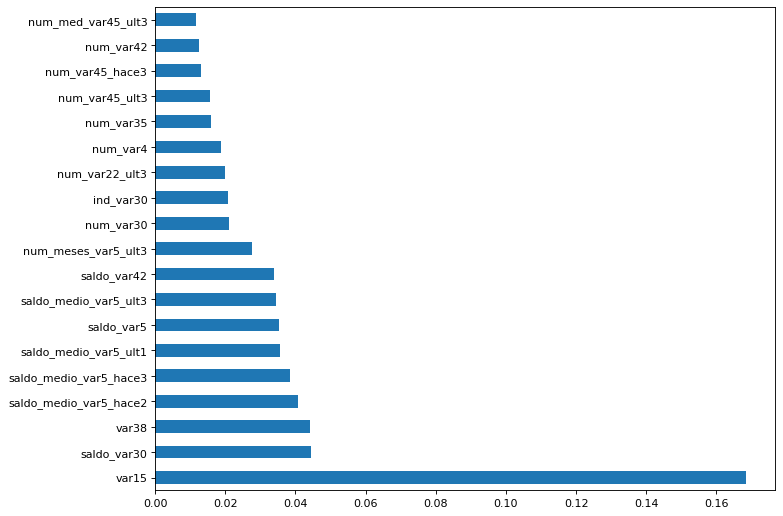

In [110]:
plt.figure(num=None, figsize=(10,8), dpi=80, facecolor='w', edgecolor='k')

feat_importance = pd.Series(rnd_clf.feature_importances_, index= x_train.columns)

feat_importance.nlargest(19).plot(kind='barh')

##### Remove Variáveis com Feature Importance abaixo de 0.01

In [222]:
to_drop_4 = []
# to_drop_4 = feature_scores.loc[lambda x: x <= feature_scores.get(key='random_var')].index[1:]
to_drop_4 = feature_scores.loc[lambda x: x <= 0.01].index

In [223]:
features_4 = features_3.drop(to_drop_4, axis=1)
features_4.head()

,var15,ind_var30,num_var4,num_var30,num_var35,num_var42,saldo_var5,saldo_var30,saldo_var42,num_var22_ult3,...,num_meses_var5_ult3,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38
61553,38,1,4,6,12,6,0.3,64139.49,64139.49,3,...,3,15,3,12,30,129.18,12.60,176.07,105.96,175887.150000
6865,51,1,1,3,3,3,1.5,1.50,1.50,3,...,3,0,3,3,6,1.50,0.72,1.50,1.23,111297.030000
847,23,1,1,3,3,3,3.0,3.00,3.00,0,...,3,0,0,0,0,3.00,0.72,3.00,2.25,117310.979016
40817,23,0,0,0,0,0,0.0,0.00,0.00,0,...,0,0,0,0,0,0.00,0.00,0.00,0.00,80805.900000
71630,23,1,1,3,3,3,120.0,120.00,120.00,9,...,3,12,0,0,12,91.98,68.28,120.00,93.42,124585.620000


##### Modelo Otimizado com Variáveis Selecionadas

In [224]:
#Separa X e Y de treino
x_train_fs = []
y_train_fs = []
x_train_fs = train_set[features_4.columns]
y_train_fs = train_set['TARGET']
x_train_fs.shape, y_train_fs.shape

((53214, 21), (53214,))

In [225]:
rnd_clf_fs = RandomForestClassifier(criterion = 'gini',
 max_depth = 15,
 max_features = 'sqrt',
 n_estimators = 100,
 class_weight = 'balanced_subsample', random_state=42)

scores_fs = cross_val_score(rnd_clf_fs, x_train_fs, y_train_fs, scoring=lucro, cv=10) #para classificacao o cv ja eh estratificado pela target

print('Media Lucro Relativo: %.3f' % mean(scores_fs))

Media Lucro Relativo: 0.209


# **Define Modelo**

In [226]:
#Separa X e Y de treino
x_train_xgb = train_set[features_4.columns]
y_train_xgb = train_set['TARGET']
x_train_xgb.shape, y_train_xgb.shape

((53214, 21), (53214,))

In [227]:
#Separa X e Y de teste
x_test_xgb = test_set[features_4.columns]
y_test_xgb = test_set['TARGET']
x_test_xgb.shape, y_test_xgb.shape

((22806, 21), (22806,))

#### Para Comparação: Acao para todos os clientes

In [205]:
y_acao = pd.Series(np.ones(len(y_train_xgb)),name='TARGET',dtype=int)

auc = roc_auc_score(y_train, y_acao.to_list())
print('ROC AUC: %.3f' % auc)
LR = funcao_lucro(y_train,y_acao.to_list())
print('Lucro Relativo: %.3f' % LR)
print('Lucro Total: %.2f' % (LR*LM))

ROC AUC: 0.500
Lucro Relativo: -1.696
Lucro Total: -321540.00


### XGBoost

#### Usa scale_pos_weight para dados desbalanceados

In [ ]:
#Gerar um modelo com Gradiente Boosting
#implementacao otimizada: XGBoost - rapido, escalonavel e portatil

##### Modelo Base

In [228]:
XGB = XGBClassifier(
   scale_pos_weight = sum(y_train_xgb == 0) / sum(y_train_xgb == 1),
   # max_depth = 6,
   # learning_rate = 0.3,
   random_state = 42
)
XGB.fit(x_train_xgb,y_train_xgb)
y_p_train = XGB.predict(x_train_xgb)
y_p_test = XGB.predict(x_test_xgb)

auc = roc_auc_score(y_train_xgb, y_p_train)
auc_test = roc_auc_score(y_test_xgb, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train_xgb, y_p_train)
LR_test = funcao_lucro(y_test_xgb, y_p_test)
print('Lucro Relativo: %.3f' % LR)
print('Lucro Relativo Teste: %.3f' % LR_test)
print('Lucro Total: %.2f' % (LR*LM))
print('Lucro Total Teste: %.2f' % (LR_test*LM))

ROC AUC: 0.902
ROC AUC Teste: 0.728
Lucro Relativo: 0.573
Lucro Relativo Teste: 0.207
Lucro Total: 108650.00
Lucro Total Teste: 39178.14


In [207]:
XGB.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'eval_metric': None,
 'gamma': 0,
 'gpu_id': -1,
 'grow_policy': 'depthwise',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_bin': 256,
 'max_cat_to_onehot': 4,
 'max_delta_step': 0,
 'max_depth': 6,
 'max_leaves': 0,
 'min_child_weight': 1,
 'monotone_constraints': '()',
 'n_jobs': 0,
 'num_parallel_tree': 1,
 'predictor': 'auto',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'sampling_method': 'uniform',
 'scale_pos_weight': 24.267806267806268,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

#### Define Hiperparâmetros

In [ ]:
# Rodei com max_depth ate 9 e n_estimators ate 100, mas o modelo overfitou

In [229]:
XGB_grid_param = {
    'n_estimators': range(10,80,10),
    'max_depth': range(3,7,3), #default 6
    'learning_rate': [0.001,0.01,0.1], #default 0.3
    'subsample': np.arange(0.25,1.01,0.25), #default 1
    'colsample_bytree': np.arange(0.25,1.01,0.25), #default 1
}

#### Random Search para escolher Hiperparâmetros

In [ ]:
#Faz Random Search para ver se teriamos algum valor melhor para os hiperparametros
#Random Search eh melhor para tunar hiperparametros com XGBoost, pois ele considera algumas combinacoes aleatorias de parametros e nao
# todas (como o Grid Search). Logo, como o XGBoost faz modelos sequenciais e, consequentemente, demora mais, melhor usar o Random. 
#https://xgboost.readthedocs.io/en/stable/parameter.html

In [230]:
random_search = RandomizedSearchCV(estimator=XGB, 
                           param_distributions=XGB_grid_param,
                           n_iter=100,
                           scoring=lucro, 
                           n_jobs=-1, 
                           cv=5)

random_search.fit(x_train_xgb,y_train_xgb)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importance_type=None,
                                           interaction_constraints='',
                                           learni...
                                           reg_alpha=0, ...),
                   iid='warn', n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': array

In [231]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=70, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=42, reg_alpha=0, ...)

In [232]:
random_search.best_params_

{'subsample': 0.25,
 'n_estimators': 70,
 'max_depth': 6,
 'learning_rate': 0.01,
 'colsample_bytree': 1.0}

In [233]:
cvres_xgb = random_search.cv_results_
for mean_score, params in zip(cvres_xgb['mean_test_score'],cvres_xgb['params']):
    print(mean_score,params)

-0.0722474042480736 {'subsample': 0.5, 'n_estimators': 40, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.25}
0.16708304917395622 {'subsample': 0.25, 'n_estimators': 20, 'max_depth': 6, 'learning_rate': 0.1, 'colsample_bytree': 0.75}
0.06710755541345828 {'subsample': 0.25, 'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
0.1551579068350693 {'subsample': 1.0, 'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.001, 'colsample_bytree': 0.5}
0.06974218095043849 {'subsample': 0.25, 'n_estimators': 70, 'max_depth': 3, 'learning_rate': 0.001, 'colsample_bytree': 0.5}
0.14302011306391457 {'subsample': 1.0, 'n_estimators': 10, 'max_depth': 6, 'learning_rate': 0.01, 'colsample_bytree': 0.75}
-0.011889454869023647 {'subsample': 0.25, 'n_estimators': 10, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.5}
0.15231029427969836 {'subsample': 0.5, 'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.75}
0.0452

#### Modelo Final

In [235]:

XGB_final = XGBClassifier(
   scale_pos_weight = sum(y_train_xgb == 0) / sum(y_train_xgb == 1),
   n_estimators = 70, #30 40 60 40 70
   max_depth = 6, #6 9 12 12 6 
   learning_rate = 0.001, #0.01 0.1 0.01 0.001 0.001
   colsample_bytree = 0.75, #1 1 1 1 0.75
   subsample = 0.25, #0.25 0.25 0.25 0.5 0.25
   random_state = 42
)
XGB_final.fit(x_train_xgb,y_train_xgb)
y_p_train = XGB_final.predict(x_train_xgb)
y_p_test = XGB_final.predict(x_test_xgb)

auc = roc_auc_score(y_train_xgb, y_p_train)
auc_test = roc_auc_score(y_test_xgb, y_p_test)
print('ROC AUC: %.3f' % auc)
print('ROC AUC Teste: %.3f' % auc_test)

LR = funcao_lucro(y_train_xgb, y_p_train)
LR_test = funcao_lucro(y_test_xgb, y_p_test)
print('Lucro Relativo: %.3f' % LR)
print('Lucro Relativo Teste: %.3f' % LR_test)
print('Lucro Total: %.2f' % (LR*LM))
print('Lucro Total Teste: %.2f' % (LR_test*LM))

ROC AUC: 0.768
ROC AUC Teste: 0.760
Lucro Relativo: 0.224
Lucro Relativo Teste: 0.200
Lucro Total: 42420.00
Lucro Total Teste: 37870.64


# **Customiza Ponto de Corte do Modelo**

In [274]:
prob_treino = XGB_final.predict_proba(x_train_xgb)[:,1]
df_avaliacao = pd.DataFrame({'Probabilidade' : prob_treino, 'TARGET' : y_train_xgb})

In [275]:
resumo_metricas = []

for corte in np.arange(0.001, 1, 0.001):
    
    # Cria o predict baseado no valor do corte
    df_avaliacao['TARGET_pred'] = (df_avaliacao['Probabilidade'] >= corte).astype('int')
    
    # Calcula o lucro
    LR = funcao_lucro(df_avaliacao['TARGET'], df_avaliacao['TARGET_pred'])
    lucro_total = LR*LM

    resumo_metricas.append([corte, LR, lucro_total])

In [276]:
resumo_metricas = pd.DataFrame(resumo_metricas, columns=["corte", "lucro_relativo", "lucro"])
resumo_metricas.loc[resumo_metricas.lucro == max(resumo_metricas['lucro'])]

,corte,lucro_relativo,lucro
507,0.508,0.283106,53660.0


### <font color='red'>  **Lucro Base de Treino**

In [283]:
print("Lucro: R$", resumo_metricas.loc[resumo_metricas.lucro == max(resumo_metricas['lucro'])]['lucro'].values[0])
print("Lucro Relativo: {:0.2%}".format(resumo_metricas.loc[resumo_metricas.lucro == max(resumo_metricas['lucro'])]['lucro_relativo'].values[0]))

Lucro: R$ 53660.0
Lucro Relativo: 28.31%


### <font color='red'>  **Lucro Base de Teste**

#### Corte = 0.51

In [284]:
prob_teste = XGB_final.predict_proba(x_test_xgb)[:,1]
pred_final = pd.DataFrame({'Probabilidade' : prob_teste, 'TARGET' : y_test_xgb})
pred_final['TARGET_pred'] = (pred_final['Probabilidade'] >= 0.508).astype('int')

LM_test = y_test_xgb.sum()*90

LR_test = funcao_lucro(pred_final['TARGET'], pred_final['TARGET_pred'])
lucro_total_test = LR_test*LM_test

print("Lucro: R$", lucro_total_test)
print("Lucro Relativo: {:0.2%}".format(LR_test))

Lucro: R$ 20200.0
Lucro Relativo: 24.88%


# **Cria faixas de atuação**

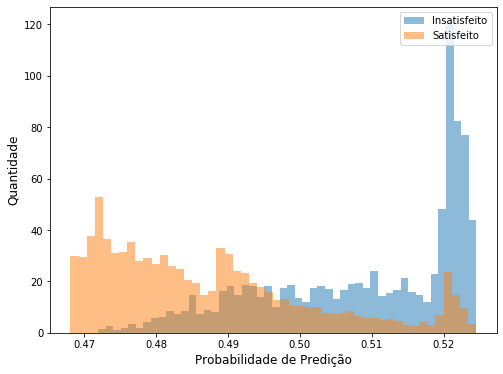

In [266]:
plt.figure(figsize=(8,6))
plt.hist(df_avaliacao.loc[(df_avaliacao.TARGET == 1)]['Probabilidade'], bins=50, density = True , alpha=0.5, label="Insatisfeito")
plt.hist(df_avaliacao.loc[(df_avaliacao.TARGET == 0)]['Probabilidade'], bins=50, density = True , alpha=0.5, label="Satisfeito")

plt.xlabel("Probabilidade de Predição", size=12)
plt.ylabel("Quantidade", size=12)
plt.legend(loc='upper right')

### Nota 1 : Probabilidade de Predição >= 0.508

### Nota 2 a 5: Probabilidade de Predição < 0.508

In [268]:
notas_treino = df_avaliacao.drop(['TARGET_pred'],axis=1)

In [285]:
nota2a5 = notas_treino.loc[notas_treino['Probabilidade'] < 0.508]
#Divide o restante do público pelos quartis
nota2a5['Probabilidade'].quantile([0.25, 0.5, 0.75])

0.25    0.474254
0.50    0.481625
0.75    0.491264
Name: Probabilidade, dtype: float64

In [286]:
condicao = [((notas_treino['Probabilidade']>=0.508) & (notas_treino['Probabilidade']<=1)),
            ((notas_treino['Probabilidade']>=0.491) & (notas_treino['Probabilidade']<0.508)),
            ((notas_treino['Probabilidade']>=0.481) & (notas_treino['Probabilidade']<0.491)),
            ((notas_treino['Probabilidade']>=0.474) & (notas_treino['Probabilidade']<0.481)),
            ((notas_treino['Probabilidade']>=0) & (notas_treino['Probabilidade']<0.474)),
            ]
valores = [1,2,3,4,5]

notas_treino['nota'] = np.select(condicao,valores)
pd.crosstab(notas_treino['nota'],notas_treino['TARGET'])

TARGET,0,1
nota,,
1,5857,1247
2,11310,573
3,12088,231
4,10716,46
5,11137,9


#### Aplica notas na Base de Teste

In [288]:
notas_teste = pred_final.drop(['TARGET_pred'],axis=1)

In [289]:
condicao = [((notas_teste['Probabilidade']>=0.508) & (notas_teste['Probabilidade']<=1)),
            ((notas_teste['Probabilidade']>=0.491) & (notas_teste['Probabilidade']<0.508)),
            ((notas_teste['Probabilidade']>=0.481) & (notas_teste['Probabilidade']<0.491)),
            ((notas_teste['Probabilidade']>=0.474) & (notas_teste['Probabilidade']<0.481)),
            ((notas_teste['Probabilidade']>=0) & (notas_teste['Probabilidade']<0.474)),
            ]
valores = [1,2,3,4,5]

notas_teste['nota'] = np.select(condicao,valores)

pd.crosstab(notas_teste['nota'],notas_teste['TARGET'])

TARGET,0,1
nota,,
1,2570,510
2,4815,250
3,5141,91
4,4511,43
5,4867,8


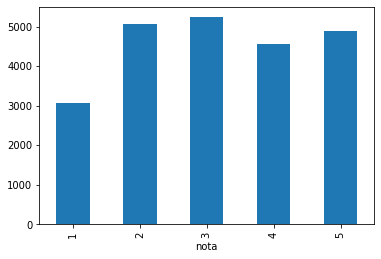

In [290]:
notas_teste.sort_values(['nota']).groupby(['nota']).size().plot.bar()

In [293]:
conditions = [
                ((notas_teste['nota'] == 1) & (notas_teste['TARGET'] == 1)),
                ((notas_teste['nota'] == 1) & (notas_teste['TARGET'] == 0)),
                (notas_teste['nota'] == 0)
            ]

values = [90,-10, 0]

notas_teste['lucro'] = np.select(conditions, values)

notas_teste.groupby(['nota']).agg(['mean','sum'])['lucro']

,mean,sum
nota,,
1,6.558442,20200
2,0.000000,0
3,0.000000,0
4,0.000000,0
5,0.000000,0


# **Clusterização**

### Padronização dos Dados

In [294]:
base_cluster = dados_nodup[features_4.columns]
base_cluster.describe()

,var15,ind_var30,num_var4,num_var30,num_var35,num_var42,saldo_var5,saldo_var30,saldo_var42,num_var22_ult3,...,num_meses_var5_ult3,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,76020.000000,7.602000e+04
mean,33.212865,0.732833,1.079440,2.382873,3.299369,2.217995,1028.468235,1.367967e+04,7.191725e+03,3.044238,...,1.979979,5.393212,3.894396,4.363496,13.651105,1579.135311,8.913659e+02,1077.256756,1048.856447,1.172358e+05
std,12.956486,0.442483,0.909566,1.642787,2.868217,1.497703,9852.140073,6.301408e+04,4.914531e+04,6.206116,...,1.298924,14.496095,10.416821,14.406485,33.304012,12148.452398,9.888597e+03,9614.906985,8189.948852,1.826646e+05
min,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2895.720000,-4.942260e+03,-4.942260e+03,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-128.370000,-8.040000e+00,-922.380000,-476.070000,5.163750e+03
25%,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,6.787061e+04
50%,28.000000,1.000000,1.000000,3.000000,3.000000,3.000000,3.000000,3.000000e+00,3.000000e+00,0.000000,...,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,9.900000e-01,3.000000,2.730000,1.064092e+05
75%,40.000000,1.000000,1.000000,3.000000,3.000000,3.000000,90.000000,2.359950e+02,1.200000e+02,3.000000,...,3.000000,3.000000,3.000000,3.000000,12.000000,90.000000,1.221750e+01,90.000000,83.790000,1.187563e+05
max,105.000000,1.000000,7.000000,33.000000,36.000000,18.000000,619329.150000,3.458077e+06,3.008077e+06,234.000000,...,3.000000,342.000000,339.000000,510.000000,801.000000,812137.260000,1.542339e+06,601428.600000,544365.570000,2.203474e+07


In [326]:
base_cluster.shape

(76020, 21)

In [322]:
scaler = StandardScaler()
valores_scl = scaler.fit_transform(base_cluster)
base_cluster_scl = pd.DataFrame(valores_scl, columns=base_cluster.columns)
base_cluster_scl.describe()

,var15,ind_var30,num_var4,num_var30,num_var35,num_var42,saldo_var5,saldo_var30,saldo_var42,num_var22_ult3,...,num_meses_var5_ult3,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38
count,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,...,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04
mean,-1.863399e-16,8.277456e-17,-7.543032e-16,2.757296e-15,-7.095292e-16,1.683210e-16,-1.031874e-15,-6.867990e-16,-6.393878e-16,6.916199e-16,...,1.435666e-16,-3.345668e-16,-1.130903e-16,-2.066391e-15,7.664175e-16,2.804511e-16,-1.694893e-15,1.319927e-15,4.191687e-16,-8.806535e-16
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-2.177523e+00,-1.656196e+00,-1.186772e+00,-1.450516e+00,-1.150328e+00,-1.480941e+00,-3.983108e-01,-2.955222e-01,-2.469018e-01,-4.905255e-01,...,-1.524332e+00,-3.720483e-01,-3.738589e-01,-3.028862e-01,-4.098964e-01,-1.405542e-01,-9.095444e-02,-2.079739e-01,-1.861961e-01,-6.135442e-01
25%,-7.882486e-01,-1.656196e+00,-1.186772e+00,-1.450516e+00,-1.150328e+00,-1.480941e+00,-1.043910e-01,-2.170906e-01,-1.463369e-01,-4.905255e-01,...,-1.524332e+00,-3.720483e-01,-3.738589e-01,-3.028862e-01,-4.098964e-01,-1.299874e-01,-9.014137e-02,-1.120410e-01,-1.280671e-01,-2.702523e-01
50%,-4.023390e-01,6.037934e-01,-8.733854e-02,3.756612e-01,-1.043752e-01,5.221394e-01,-1.040865e-01,-2.170430e-01,-1.462759e-01,-4.905255e-01,...,7.852867e-01,-3.720483e-01,-3.738589e-01,-3.028862e-01,-4.098964e-01,-1.297404e-01,-9.004126e-02,-1.117290e-01,-1.277338e-01,-5.927104e-02
75%,5.238442e-01,6.037934e-01,-8.733854e-02,3.756612e-01,-1.043752e-01,5.221394e-01,-9.525589e-02,-2.133455e-01,-1.438951e-01,-7.128235e-03,...,7.852867e-01,-1.650947e-01,-8.586133e-02,-9.464525e-02,-4.957708e-02,-1.225790e-01,-8.890585e-02,-1.026805e-01,-1.178362e-01,8.323742e-03
max,5.540670e+00,6.037934e-01,6.509259e+00,1.863744e+01,1.140111e+01,1.053754e+01,6.275842e+01,5.466112e+01,6.106188e+01,3.721446e+01,...,7.852867e-01,2.322067e+01,3.216987e+01,3.509807e+01,2.364142e+01,6.672154e+01,1.558824e+02,6.244005e+01,6.633989e+01,1.199885e+02


## **K-Means**

### Define k

#### Método de Elbow

In [312]:
distorcao = []

for k in range(2, 15):
    kmeans = KMeans(n_clusters = k, init = "k-means++", n_init = 15,  random_state = 42)
    kmeans.fit(valores_scl)
    distorcao.append(kmeans.inertia_)

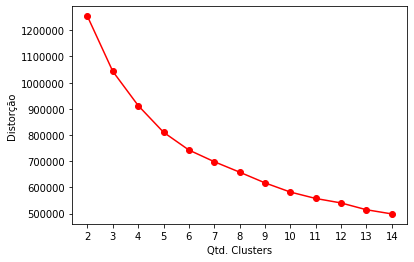

In [313]:
plt.plot(range(2, 15), distorcao, color = 'red', marker = 'o', linestyle = '-')
plt.xticks(range(2, 15))
plt.xlabel("Qtd. Clusters")
plt.ylabel("Distorção")
plt.show()

#### Método Silhueta

In [315]:
coef_silhouette = []

for k in range(2, 7):
    kmeans = KMeans(n_clusters = k, init = "k-means++", n_init = 15,  random_state = 42)
    kmeans.fit(valores_scl)
    coef = silhouette_score(valores_scl, kmeans.labels_)
    coef_silhouette.append(coef)

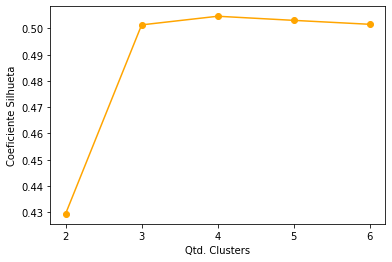

In [316]:
plt.plot(range(2, 7), coef_silhouette, color = 'orange', marker = 'o', linestyle = '-')
plt.xticks(range(2, 7))
plt.xlabel("Qtd. Clusters")
plt.ylabel("Coeficiente Silhueta")
plt.show()

### Modelo Final (k=4)

In [318]:
kmeans_final = KMeans(n_clusters=4, init = "k-means++", n_init=15,  random_state = 42)

## Define Clusters

In [323]:
cluster = kmeans_final.fit_predict(valores_scl)
base_cluster_scl['cluster'] = cluster

### Adiciona Target e Predição do Modelo de Classificação

In [324]:
base_cluster_scl['TARGET'] = dados_nodup['TARGET']

classif = XGB_final.predict_proba(base_cluster)[:,1]
base_cluster_scl['Probabilidade'] = classif
base_cluster_scl['TARGET_pred'] = (base_cluster_scl['Probabilidade'] >= 0.508).astype('int')
base_cluster_scl

,var15,ind_var30,num_var4,num_var30,num_var35,num_var42,saldo_var5,saldo_var30,saldo_var42,num_var22_ult3,...,num_var45_ult3,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,var38,cluster,TARGET,Probabilidade,TARGET_pred
0,-0.788249,-1.656196,-1.186772,-1.450516,-1.150328,-1.480941,-0.104391,-0.217091,-0.146337,-0.490526,...,-0.409896,-0.129987,-0.090141,-0.112041,-0.128067,-0.427183,0,0,0.495222,0
1,0.060753,0.603793,-0.087339,0.375661,-0.104375,-1.480941,-0.104391,-0.212330,-0.146337,-0.490526,...,-0.409896,-0.129987,-0.081152,-0.112041,-0.128067,-0.372038,3,0,0.491496,0
2,-0.788249,0.603793,-0.087339,0.375661,-0.104375,0.522139,-0.104087,-0.217043,-0.146276,-0.490526,...,-0.409896,-0.129740,-0.090123,-0.111729,-0.127814,-0.273191,3,0,0.471996,0
3,0.292298,0.603793,2.111527,0.375661,1.987531,0.522139,-0.097223,-0.215970,-0.144900,-0.007128,...,1.031381,-0.114669,-0.090141,-0.102518,-0.111115,-0.291398,1,0,0.497543,0
4,0.446662,0.603793,-0.087339,0.375661,-0.104375,0.522139,-0.104391,1.925350,2.600698,0.959666,...,-0.409896,-0.129740,-0.090111,4.100308,1.520485,0.000412,3,0,0.476479,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76015,1.141300,-1.656196,-1.186772,-1.450516,-1.150328,-1.480941,-0.104391,-0.217091,-0.146337,-0.490526,...,-0.409896,-0.129987,-0.090141,-0.112041,-0.128067,-0.308268,0,0,0.522668,1
76016,0.446662,0.603793,-0.087339,0.375661,-0.104375,0.522139,-0.104391,0.547684,0.834256,3.376653,...,1.031381,-0.119233,-0.090141,-0.112041,-0.128067,0.007657,1,0,0.485539,0
76017,-0.788249,0.603793,-0.087339,0.375661,-0.104375,0.522139,-0.104087,-0.217043,-0.146276,-0.490526,...,-0.409896,-0.129740,-0.090141,-0.111729,-0.127701,-0.236543,3,0,0.471927,0
76018,-0.633885,0.603793,-0.087339,0.375661,-0.104375,0.522139,-0.104087,-0.217043,-0.146276,-0.490526,...,-0.409896,-0.129740,-0.089965,-0.111729,-0.127752,-0.180428,3,0,0.479254,0


### Verifica Qtd. Cliente e Lucro por Cluster

In [349]:
lucro_cluster = []

for k in range (0,4,1):
    base_k = base_cluster_scl[base_cluster_scl['cluster'] == k]

    qtdd = base_k['cluster'].shape[0]

    LM_cluster = base_k['TARGET'].sum()*90
    LR_cluster = funcao_lucro(base_k['TARGET'], base_k['TARGET_pred'])
    lucro_total_cluster = LR_cluster*LM_cluster

    lucro_cliente = lucro_total_cluster/qtdd

    lucro_cluster.append([k, qtdd, LR_cluster, lucro_total_cluster, lucro_cliente])


lucro_cluster = pd.DataFrame(lucro_cluster, columns=["Cluster", "Qtd_Cli", "Lucro_Relativo", "Lucro_Total", "Lucro_Pessoa"])

In [350]:
lucro_cluster = lucro_cluster
lucro_cluster

,Cluster,Qtd_Cli,Lucro_Relativo,Lucro_Total,Lucro_Pessoa
0,0,20191,0.394138,63070.0,3.123669
1,1,8208,0.227001,5700.0,0.694444
2,2,196,0.000000,0.0,0.000000
3,3,47425,0.059658,5090.0,0.107327


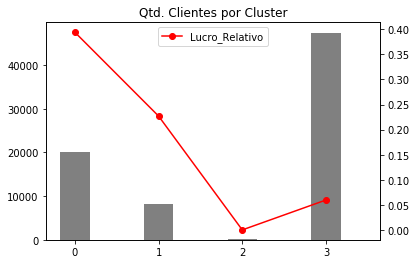

In [359]:
width = .35
lucro_cluster['Qtd_Cli'].plot(kind='bar', color='gray', width=width)
lucro_cluster['Lucro_Relativo'].plot(kind='line', marker='o', color='red', secondary_y=True)
ax = plt.gca()
plt.xlim([-width, len(lucro_cluster['Qtd_Cli'])-width])
plt.legend(loc='upper center')
plt.title("Qtd. Clientes por Cluster")

plt.show()